# 3rd practice: Neural Networks
* **Course**: Artificial Intelligence
* **University**: Universitat Rovira i Virgili

In this practice students will explore the following fundamentals of machine learning:
* Data analysis
* Preprocessing
* Basic design of Multi-Layer Perceptrons (MLP)
* Training of neural networks
* Results analysis
* Decision making / Critical thinking

While reading this notebook, please note the following information:
* Each section (and subsection) has a title and a brief description of its contents.
* If a section (or subsection) title starts with `Student`, the student has work to do inside it, adding code and/or text.
* If the title of a section begins with `Teacher`, all its content (including subsections) is part of the work statement. Subsequently, it **MUST NOT** be modified.
* Sections must be executed in order.
* **<font color='lightgreen'>Please enter your full name in the next cell in this section and run it BEFORE going any further.</font>**

## External resources
Please, read the following tutorials to get an introduction to Google Colab and the Pandas library:
* https://colab.research.google.com/notebooks/basic_features_overview.ipynb
* https://colab.research.google.com/notebooks/mlcc/intro_to_pandas.ipynb

## Deliverable
It is an **individual** practice. The student only needs to deliver **this notebook** including the answers. The file must have as name `P3_[Name]_[Surname/s].ipynb`, replacing `[Name]` and `[Surname/s]` with those from the student.

## Evaluation
To be accepted, all practices delivered must contain at least **one solution with a preprocessing step** and **one solution with a modified neural network**.
A third solution with a second preprocessing step will be valued.

<font color='orange'>**Similar or identical practices will get a grade of 0.**</font>

In [1]:
STUDENT_NAME = "GERARD PASCUAL FONTANILLES" # @param {type:"string"}

# Teacher: Initialization
Defines the **Imports** and **Device** for the practice. More details in each subsection.

## Imports
The following code cell determines the available packages/libraries.

**You CANNOT add any other import, neither here nor anywhere else in the code.**

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Device
Checks if there is a GPU for training the neural networks. If not, the CPU will be used. It is recommended to first test if the preprocessing and model definition are correct in a CPU-based environment and then switch to the GPU-based environment for training.

In [3]:
if torch.cuda.is_available():
  DEVICE = "cuda"
  print("There is GPU available. Printing GPU information:")
  !nvidia-smi
else:
  DEVICE = "cpu"
  print("There is no GPU available, using CPU.")

There is GPU available. Printing GPU information:
Mon May 13 16:54:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 970         Off | 00000000:29:00.0  On |                  N/A |
|  0%   58C    P2              46W / 200W |    360MiB /  4096MiB |     16%      Default |
|                                         |                      |                  N/A |
+-----------------

# Teacher: Base code
<a name="base_code"></a>

Code available for use in the `Student` sections.

## Data loading
This loads the `CarsData.csv` file (available in Moodle) as a Pandas dataframe. **The file must first be loaded into the environment folder** 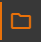. If you use a web browser *other* than Google Chrome, the loading may fail (e.g., the loading circle is red and never ends).

This dataset will be used for the **Manufacturer classification task**, where the machine learning model aims to predict/output the Manufacturer of a car using the rest of features as inputs.

The dataset was extracted from [this website](https://www.kaggle.com/datasets/meruvulikith/90000-cars-data-from-1970-to-2024/data). The dataframe to be used in practice is a 25% subsample of the full dataset, different from that of other students.

In [4]:
LABEL_COL_NAME = "Manufacturer" # Global constant

def data_loading(file_name):
  original_df = pd.read_csv(file_name)
  original_df = original_df.drop(columns=["model"]) # Model column is not available
  original_df

  # Infer column types
  infer_type = lambda x: x if pd.api.types.is_numeric_dtype(x) else pd.Categorical(x)
  original_df = original_df.apply(infer_type, axis=0)

  # Select subset
  frac=0.25
  random_seed = hash(STUDENT_NAME) % (2**32-1) # Seed must be between 0 and 2**32 - 1
  student_df = original_df.sample(frac=frac, random_state=random_seed).reset_index()
  student_df = student_df.drop(columns=["index"])

  return student_df

## Analysis
Functions that facilitate the data distribution analysis for the [Student: Exploratory data analysis](#data_analysis) section.

In [5]:
def feature_histogram(df, column_name):
    column_data = df[column_name]

    if pd.api.types.is_numeric_dtype(column_data):
        plt.hist(column_data, bins=10)
    else:
        value_counts = column_data.value_counts()
        value_counts.plot(kind='bar')

    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title('Histogram of {}'.format(column_name))
    plt.show()

In [6]:
def feature_stats(df, column_name, verbose=True):
  stats = {}
  column_data = df[column_name]

  # Numerical
  if pd.api.types.is_numeric_dtype(column_data):
    stats["Min"] = column_data.min()
    stats["Max"] = column_data.max()
    stats["Mean"] = column_data.mean()
    stats["Std"] = column_data.std()

  # Categorical
  elif pd.api.types.is_categorical_dtype(column_data):
    stats["Unique"] = column_data.value_counts()

  if verbose and len(stats) > 0:
    stats_str = ""
    for name, value in stats.items():
      stats_str += f" {name}={value} |"
    print(f"Stats of {column_name}:{stats_str}")

  return stats

In [7]:
def features_relationship(df, column_name_1, column_name_2):
    data1 = df[column_name_1]
    data2 = df[column_name_2]

    # Both columns are numerical
    if pd.api.types.is_numeric_dtype(data1) and pd.api.types.is_numeric_dtype(data2):
        plt.scatter(data1, data2)
        plt.xlabel(column_name_1)
        plt.ylabel(column_name_2)
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # Both columns are categorical
    elif pd.api.types.is_categorical_dtype(data1) and pd.api.types.is_categorical_dtype(data2):
        cross_table = pd.crosstab(data1, data2)
        cross_table.plot(kind='bar', stacked=True)
        plt.xlabel(column_name_1)
        plt.ylabel('Frequency')
        plt.title('Relationship between {} and {}'.format(column_name_1, column_name_2))
        plt.show()
    # A column is numerical and the other categorical
    else:
        # Check which is which
        if pd.api.types.is_categorical_dtype(data1):
            categorical_column = column_name_1
            numerical_column = column_name_2
        else:
            categorical_column = column_name_2
            numerical_column = column_name_1

        # Get data
        categorical_data = df[categorical_column]
        numerical_data = df[numerical_column]

        # Convert categorical data to numeric representation
        categorical_codes = categorical_data.astype('category').cat.codes

        # Plot
        plt.scatter(numerical_data, categorical_codes)
        plt.xlabel(numerical_column)
        plt.ylabel(categorical_column)
        plt.title('Relationship between {} and {}'.format(numerical_column, categorical_column))
        plt.yticks(ticks=categorical_codes.unique(), labels=categorical_data.unique()) # Set sticks labels as category names
        plt.show()

## PyTorch dataset
Function that transforms the preprocessed dataframe into the training and test datasets using the PyTorch TensorDataset class. To be used in the [Experiments](#experiments) section.

In [8]:
def df_to_dataset(preprocessed_df, label_col_name=LABEL_COL_NAME):
  if not label_col_name in preprocessed_df.columns:
    raise Exception(f"Dataframe MUST contain the label column [{label_col_name}], preferably in the last column.")

  # Obtain inputs and labels
  columns_to_discard = [col_name for col_name in preprocessed_df.columns if col_name == label_col_name]
  x = preprocessed_df.drop(columns=columns_to_discard)
  y = preprocessed_df[label_col_name]

  # Encode labels (string to identifier integer)
  label_encoder = LabelEncoder()
  y = label_encoder.fit_transform(y)

  # Convert data to PyTorch tensors
  x_tensor = torch.tensor(x.values, dtype=torch.float)
  y_tensor = torch.tensor(y, dtype=torch.long)

  # Train-test split: 80% train, 20% test
  x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42, shuffle=True)

  # Create PyTorch datasets
  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

  # Get additional information for the model
  input_size = x_train_tensor.shape[1]
  num_classes = len(label_encoder.classes_)

  return train_dataset, test_dataset, input_size, num_classes, label_encoder

## Model
Basic function for the model creation and its movement to the corresponding DEVICE (GPU or CPU). To be used in the [Experiments](#experiments) section.

In [9]:
def create_model(model_class, input_size, num_classes, verbose=True):
  model = model_class(input_size, num_classes)
  model.to(DEVICE)

  if verbose:
    num_parameters = 0
    for layer in model.parameters():
      num_parameters += layer.nelement() * layer.element_size()
    print(f"The model has {num_parameters} parameters")

  return model

## Training
Function that trains a **model** with a **dataset**, for a **number of epochs** and using a specific **learning rate (lr)**. To be used in the [Experiments](#experiments) section.

In [10]:
def train(model, dataset, num_epochs, lr):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create PyTorch dataloader
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Set up loss evolution plot
    losses = []
    plt.ion()
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Evolution')
    line, = ax.plot([], [])

    # Training loop
    for epoch in range(num_epochs):
        # Set model to train mode
        model.train()

        epoch_loss = 0.0
        num_batches = 0

        for inputs, targets in train_loader:
            # Move data to GPU
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update epoch loss
            epoch_loss += loss.item()
            num_batches += 1

        # Update lists for loss plotting
        mean_epoch_loss = epoch_loss / num_batches
        losses.append(mean_epoch_loss)

        # Update plot
        line.set_ydata(losses)
        line.set_xdata(range(1, len(losses)+1))
        ax.relim()
        ax.autoscale_view()
        display.clear_output(wait=True)
        display.display(plt.gcf())

        # Print specific epoch info
        print(f'Epoch [{epoch+1}/{num_epochs}] | Mean epoch loss: {mean_epoch_loss:.4f}')

    # Turn off interactive mode and show plot
    plt.ioff()
    plt.close()

    return losses

## Evaluation
Functions for the result analysis of the [Experiments](#experiments) section. In particular, for the analysis of [classification accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy?hl=es-419) and [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).


In [11]:
def evaluate(model, dataset):
  # Create dataloader
  eval_loader = DataLoader(dataset, batch_size=256, shuffle=False)

  model.eval()  # Set model to evaluation mode
  with torch.no_grad():
      correct = 0
      total = 0
      all_targets = np.empty(len(dataset), dtype=int)
      all_predicted = np.empty_like(all_targets)
      for inputs, targets in eval_loader:
          # Move data to GPU
          inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

          # Forward pass
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)

          # Store targets and predicted labels
          all_targets[total:total+targets.size(0)] = targets.cpu().numpy()
          all_predicted[total:total+targets.size(0)] = predicted.cpu().numpy()

          # Update total and correct predictions
          total += targets.size(0)
          correct += (predicted == targets).sum().item()

      accuracy = correct / total

  return accuracy, all_targets, all_predicted


def plot_confusion_matrix(all_targets, all_predicted, label_encoder):
  # Calculate confusion matrix
  cm = confusion_matrix(all_targets, all_predicted)

  # Plot confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

# Student: Exploratory data analysis
<a name="data_analysis"></a>

In this section, the student will have to perform the following tasks:
* Load the dataset.
* Analyze each feature's data distribution using plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per feature) about them.
* Analyze relevant relationships between pairs of features' data distributions with plots, Pandas code (if needed) and textual reasoning (approximately one paragraph per relationship) about them. Focus only on the important pairs to avoid overwhelming combinations.

In [12]:
df = data_loading("CarsData.csv")

In [13]:
df.head() # Show the first rows of the dataframe to check the data

,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Manufacturer
0,2017,12599,Manual,43756,Diesel,145,68.9,2.0,volkswagen
1,2016,23990,Automatic,25614,Hybrid,20,55.4,2.5,toyota
2,2016,6999,Manual,38658,Petrol,125,54.3,1.4,vauxhall
3,2017,9670,Manual,17151,Petrol,145,51.4,1.4,vauxhall
4,2018,10500,Manual,10995,Petrol,145,65.7,1.0,ford


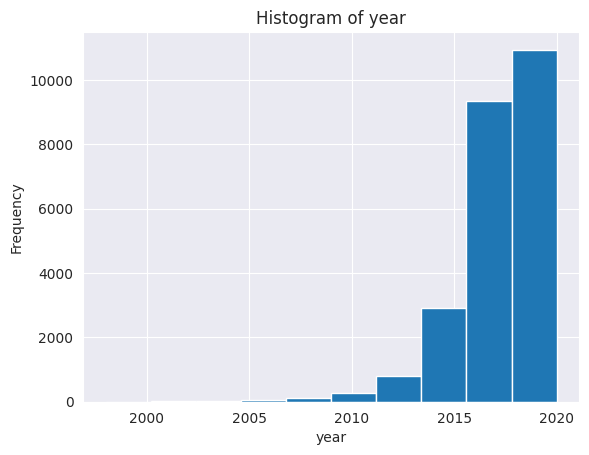

In [14]:
feature_histogram(df, "year")

In [15]:
feature_stats(df, "year")

Stats of year: Min=1998 | Max=2020 | Mean=2017.0700425740954 | Std=2.0991429196417375 |


{'Min': 1998,
 'Max': 2020,
 'Mean': 2017.0700425740954,
 'Std': 2.0991429196417375}

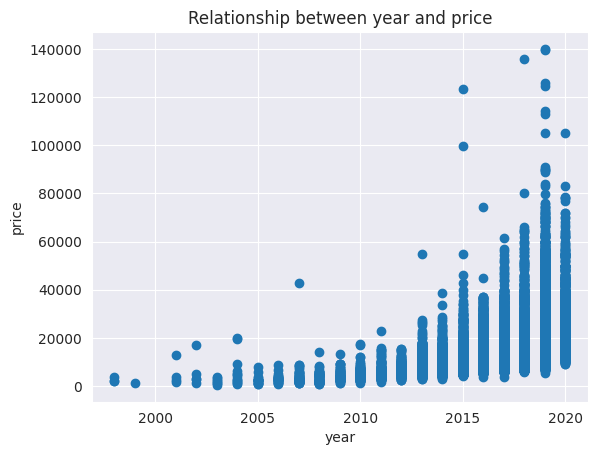

In [16]:
features_relationship(df, "year", "price")

# Teacher: Baseline solution
<a name="baseline"></a>
This defines the most basic (and unsuccessful) ready-to-use solution for the **Manufacturer classification task**. It includes the main components:
* Preprocessing
* Model
* Training
* Evaluation

Nonetheless, there are a lot of important things missing, as can be seen from the very poor results. Use this as inspiration for your [Solution 1A](#solution_1a), that **must** be better than this.

## Preprocessing

In [17]:
def preprocessing_0(df):
  preprocessed_df = df.copy()

  # Define columns to use and categorical
  categorical_cols = ["transmission", "fuelType"]
  columns_to_use = ["year", "price", "mileage", "tax", "mpg", "engineSize"] + categorical_cols

  # Select columns to use
  preprocessed_df = preprocessed_df[columns_to_use]

  # Column transformer of the features
  column_transformer = ColumnTransformer([('onehot', OneHotEncoder(), categorical_cols)],
                                         remainder='passthrough')
  preprocessed_df = pd.DataFrame(column_transformer.fit_transform(preprocessed_df))
  # IMPORTANT: Student's can't use ColumnTransformer or similars, only Pandas functions

  # Label column at the end
  preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

  return preprocessed_df

preprocessed_df = preprocessing_0(df)
train_dataset, test_dataset, input_size, num_classes, label_encoder = df_to_dataset(preprocessed_df)

In [18]:
input_size

15

In [19]:
num_classes

9

## Model

In [20]:
class Model_0(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Model_0, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, num_classes), # Input layer to output layer, tantes neurones com classes
            nn.Softmax(dim=1) # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)

model = create_model(Model_0, input_size, num_classes)

The model has 576 parameters


## Training

In [21]:
%%time
losses = train(model, train_dataset, num_epochs=5, lr=0.001)

Epoch [5/5] | Mean epoch loss: 2.1883
CPU times: user 6.5 s, sys: 509 ms, total: 7.01 s
Wall time: 6.96 s


## Evaluation

Train accuracy: 18.37%
Test accuracy: 18.34%


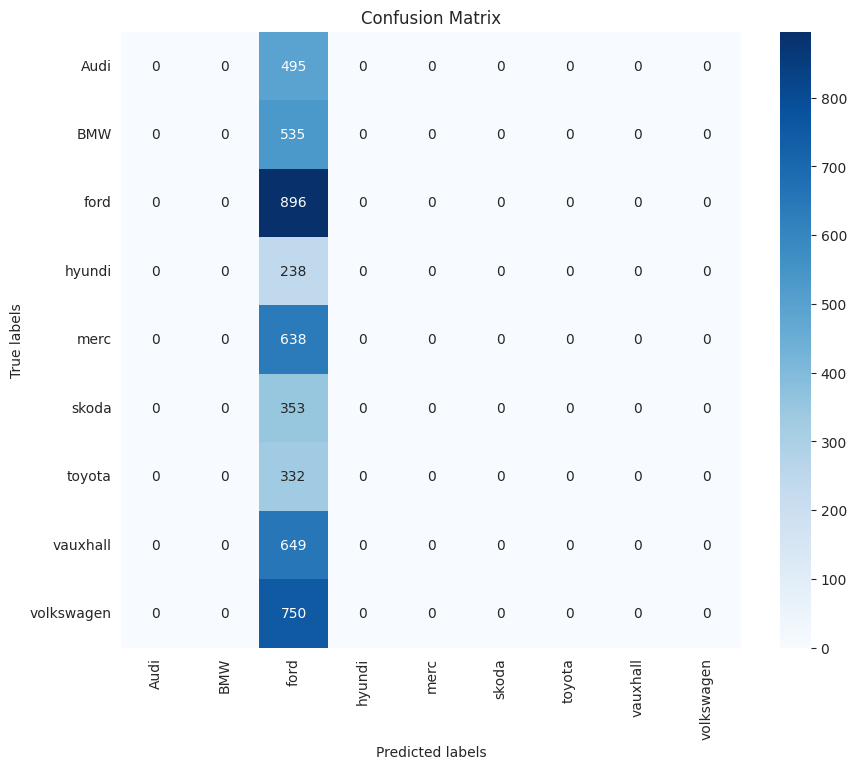

In [22]:
train_accuracy, _, _ = evaluate(model, train_dataset)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

# Student: Experiments
<a name="experiments"></a>

In this section, the student will have to create two or three consequent solutions for the **Manufacturer classification task**. Each solution must contain the following components:
* **Idea**: What is the target/reasoning of the solution (e.g., I observed that the previous model had a very reduced size and I want to explore the effects of using a bigger model).
* **Preprocessing**: Prepare the desired features of your dataframe for the neural network. To this end, students can <font color='orange'>**only use Pandas' functions**</font>.
* **Model**: Definition of the Multi-Layer Perceptron model, **only** using [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers and
 [activations from this list](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity).
* **Training**: Perform the learning process trying to maximize the results.
* **Evaluation**: Measuring the performance of the trained model.
* **Results analysis**: Examination of the solution, focusing in:
  * Training
  * Accuracy
  * Confusion matrix
  * Training time

It can be seen that these are the same as for the baseline solution, but adding the **Idea** and **Results analysis** components. An extended analysis of the baseline results will also be requested.

None of the solutions has to be the best/ideal, but all of them must be better than the [baseline](#baseline). The idea is to present consequent solutions, being each one the coherent next step of the previous one (the previous step of [Solution 1A](#solution_1a) is the [baseline](#baseline)). This does not imply that each solution has to improve the results of the previous one, but to modify at least one of the components (i.e., preprocessing or model) in a significant and coherent way.

In particular, we aim for the first two solutions ([Solution 1A](#solution_1a) and [Solution 1B](#solution_1b)) to emphasize preprocessing. Specifically, both will utilize the same basic MLP model (better than that of the [baseline](#baseline)) but experiment with two distinct preprocessing approaches. An explicit comparison of these preprocessing methods and their respective outcomes is necessary. For [Solution 2](#solution_2), the preprocessing method from one of the earlier solutions will be employed. The goal of this final solution is to enhance results by improving/refining the MLP model.

## Analysis of baseline
Provide a comprehensive analysis of the [baseline solution](#baseline). Apart from the results (i.e., **training, accuracy, confusion matrix and runtime**), a review of the solution design (i.e., **preprocessing and model**) is also required. It is not necessary to explain or analysis the code, but the choices. For instance, which features are used and how.

TODO: YOUR ANALYSIS HERE

## Common functions
For avoiding code repetition along all the solutions, you can use this subsection for your common functions and/or classes.

In [23]:
df = data_loading("CarsData.csv")

In [24]:
def min_max_scaling(df, cols):
    for col in cols:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

## Solution 1A: First preprocessing
<a name="solution_1a"></a>

Subsequent of [Baseline](#baseline), it implements a basic MLP (better than the provided at the baseline) and a first option for the preprocessing step.

In [25]:
preprocessed_df = df.copy()
# Define columns to use and categorical
categorical_cols = ["transmission", "fuelType"]
test_df = preprocessed_df[categorical_cols]

for col in categorical_cols:
    new_column_data = pd.get_dummies(test_df[col], prefix=col)
    test_df = pd.concat([test_df, new_column_data], axis=1)

test_df

,transmission,fuelType,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,Manual,Diesel,False,True,False,False,True,False,False,False,False
1,Automatic,Hybrid,True,False,False,False,False,False,True,False,False
2,Manual,Petrol,False,True,False,False,False,False,False,False,True
3,Manual,Petrol,False,True,False,False,False,False,False,False,True
4,Manual,Petrol,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
24423,Manual,Diesel,False,True,False,False,True,False,False,False,False
24424,Manual,Petrol,False,True,False,False,False,False,False,False,True
24425,Manual,Diesel,False,True,False,False,True,False,False,False,False
24426,Manual,Petrol,False,True,False,False,False,False,False,False,True


In [26]:
def preprocessing_1(df):
    preprocessed_df = df.copy()

    # Define columns to use and categorical
    categorical_cols = ["transmission", "fuelType"] 
    numerical_cols = ["year", "price", "mileage", "tax", "mpg", "engineSize"]
    columns_to_use = numerical_cols + categorical_cols

    # Select columns to use
    preprocessed_df = preprocessed_df[columns_to_use]

    # One-hot encoding for categorical columns
    for old_col in categorical_cols:
        # One-hot encoding for that column 
        one_hot_encoding_df = pd.get_dummies(preprocessed_df[old_col])

        # Append the new columns to the preprocessed dataframe
        for new_col in one_hot_encoding_df.columns:
            preprocessed_df[new_col] = one_hot_encoding_df[new_col] * 1  # Convert boolean to int

        # Remove the old categorical column
        del preprocessed_df[old_col]

    
    # Normalize numerical columns
    for col in numerical_cols:
        # Min-max normalization o standard deviation normalization depend de l'anàlisi anterior
        preprocessed_df[col] = ((preprocessed_df[col] - preprocessed_df[col].min()) / (preprocessed_df[col].max() - preprocessed_df[col].min()))
    
    # Label column at the end
    preprocessed_df[LABEL_COL_NAME] = df[LABEL_COL_NAME]

    return preprocessed_df


preprocessed_df1A = preprocessing_1(df)
train_dataset1A, test_dataset1A, input_size1A, num_classes1A, label_encoder1A = df_to_dataset(preprocessed_df1A)

In [27]:
input_size1A

14

In [28]:
num_classes1A

9

In [29]:
train_dataset1A[0]

(tensor([0.8636, 0.1685, 0.1097, 0.2586, 0.1231, 0.3030, 0.0000, 0.0000, 0.0000,
         1.0000, 1.0000, 0.0000, 0.0000, 0.0000]),
 tensor(0))

In [30]:
label_encoder1A.classes_

array(['Audi', 'BMW', 'ford', 'hyundi', 'merc', 'skoda', 'toyota',
       'vauxhall', 'volkswagen'], dtype=object)

In [31]:
class Model_1A(nn.Module):
    def __init__(self, input_size1A, num_classes1A):
        super(Model_1A, self).__init__() 
        self.layers = nn.Sequential( # Capa per capa el que volem que faci
            nn.Linear(input_size1A, num_classes1A), # Input layer to output layer, tantes neurones com classes
            # nn.Linear(input_size1A, num_classes1A), # input_size neurones a la capa d'entrada
            #nn.Linear(input_size1A, num_classes1A), # num_classes neurones a la capa de sortida
          
            nn.Softmax(dim=1) # Mandatory activation to normalize probabilities between 0 and 1
        )

    def forward(self, x):
        return self.layers(x)

model1A = create_model(Model_1A, input_size1A, num_classes1A)

The model has 540 parameters


In [32]:
preprocessed_df1A

,year,price,mileage,tax,mpg,engineSize,Automatic,Manual,Other,Semi-Auto,Diesel,Electric,Hybrid,Petrol,Manufacturer
0,0.863636,0.086796,0.168939,0.250000,0.144347,0.303030,0,1,0,0,1,0,0,0,volkswagen
1,0.818182,0.168480,0.098892,0.034483,0.115606,0.378788,1,0,0,0,0,0,1,0,toyota
2,0.818182,0.046639,0.149255,0.215517,0.113264,0.212121,0,1,0,0,0,0,0,1,vauxhall
3,0.863636,0.065793,0.066216,0.250000,0.107090,0.212121,0,1,0,0,0,0,0,1,vauxhall
4,0.909091,0.071745,0.042448,0.250000,0.137535,0.151515,0,1,0,0,0,0,0,1,ford
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24423,0.954545,0.200749,0.006981,0.250000,0.109006,0.303030,0,1,0,0,1,0,0,0,skoda
24424,0.909091,0.109184,0.069035,0.250000,0.094741,0.227273,0,1,0,0,0,0,0,1,ford
24425,0.818182,0.063412,0.061923,0.051724,0.134341,0.242424,0,1,0,0,1,0,0,0,hyundi
24426,0.772727,0.045858,0.114788,0.215517,0.104961,0.212121,0,1,0,0,0,0,0,1,hyundi


In [33]:
%%time
losses1A = train(model1A, train_dataset1A, num_epochs=5, lr=0.005)

Epoch [5/5] | Mean epoch loss: 2.0503
CPU times: user 4.96 s, sys: 262 ms, total: 5.22 s
Wall time: 5.06 s


Train accuracy: 33.78%
Test accuracy: 18.34%


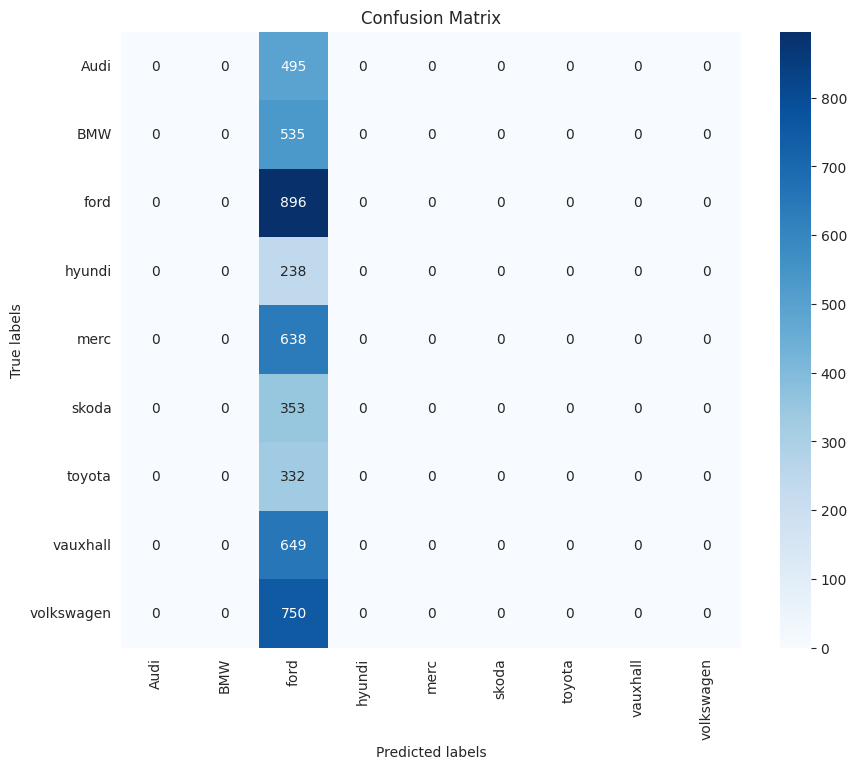

In [34]:
train_accuracy, _, _ = evaluate(model1A, train_dataset1A)
test_accuracy, test_all_targets, test_all_predicted = evaluate(model, test_dataset)

print(f'Train accuracy: {train_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

plot_confusion_matrix(test_all_targets, test_all_predicted, label_encoder)

## Solution 1B: Second preprocessing solution
<a name="solution_1b"></a>

Subsequent of the [Solution 1A](#solution_1a), uses the same basic MLP but with an alternative preprocessing step.

In [ ]:
 # COMPARAR EL PREPROCESSAT, MODEL HA DE SER EL MATEIX, JA EL TINC, EL QUE VALORA ES ANALYSIS DELS RESULTATS I EL PREPROCESSAT

In [39]:
def preprocessing_2(df):
    preprocessed_df = df.copy()

    # Define columns to use and categorical
    categorical_cols = ["transmission", "fuelType"]
    numerical_cols = ["year", "price", "mileage", "tax", "mpg", "engineSize"]
    columns_to_use = numerical_cols + categorical_cols

    # Select columns to use
    preprocessed_df = preprocessed_df[columns_to_use]

    # One-hot encoding for categorical columns
    for col in categorical_cols:
        onehot_encoder = OneHotEncoder()
        onehot_encoded = onehot_encoder.fit_transform(preprocessed_df[[col]])
        onehot_df = pd.DataFrame(onehot_encoded.toarray(), columns=[f"{col}_{cat}" for cat in onehot_encoder.categories_[0]])
        preprocessed_df = pd.concat([preprocessed_df, onehot_df], axis=1)
        preprocessed_df.drop(col, axis=1, inplace=True)

    # Min-max scaling for numerical columns
    for col in numerical_cols:
        preprocessed_df[col] = (preprocessed_df[col] - preprocessed_df[col].min()) / (preprocessed_df[col].max() - preprocessed_df[col].min())


    return preprocessed_df

preprocessed_df1B = preprocessing_2(df)
train_dataset1B, test_dataset1B, input_size1B, num_classes1B, label_encoder1B = df_to_dataset(preprocessed_df1B)

Exception: Dataframe MUST contain the label column [Manufacturer], preferably in the last column.

## Solution 2: New model solution
<a name="solution_2"></a>

Subsequent of either [Solution 1A](#solution_1a) or [Solution 1B](#solution_1b), uses the same preprocessing step but improves the MLP model.

In [ ]:
# TODO: YOUR CODE HERE